Remove Noisy images

In [ ]:
img_exts = ['jpg', 'jpeg', 'png', 'bmp']

In [ ]:

import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import imghdr
from tensorflow.keras.preprocessing import image_dataset_from_directory


data_dir = '../Preprocessing/Processed_Images'

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in img_exts:
                print(image_path)    # print the path of the image with unknown extension
                os.remove(image_path)
        except Exception as e:
            print("Issue with image:" .format(image_path))
            
            


Load Dataset

In [ ]:
batch_size = [16,32]
for size in batch_size:
   data = tf.keras.utils.image_dataset_from_directory('../Preprocessing/Processed_Images', batch_size=size, image_size=(256, 256), shuffle=True) #Data pipeline

class_names = data.class_names #get the class names
print(class_names)

data_iterator = data.as_numpy_iterator() #allows us to access Data pipeline

batch = data_iterator.next() #get the next batch of data



In [ ]:
batch[0].shape # shape of the batch

In [ ]:
batch[1] # labels

Plotting Images

In [ ]:
from matplotlib import pyplot as plt
rows = 4
cols = 8
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 12))
fig.suptitle('Sample Images with Class Labels', fontsize=16)

# Flatten axes for easier indexing
axes = axes.flatten()

# Display images in grid
for idx, (image, label) in enumerate(zip(batch[0][:32], batch[1][:32])):
    # Get class name from label index
    class_name = class_names[label]
    
    # Display image
    axes[idx].imshow(image.astype("uint8"))
    axes[idx].set_title(f'{class_name}', fontsize=8)
    axes[idx].axis('off')

# Add color-coded legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=f'C{i}', markersize=10, 
                             label=name) for i, name in enumerate(class_names)]
fig.legend(handles=legend_elements, loc='center right')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for legend
plt.show()

Preprocessing 

Scaling Data

In [ ]:
data = data.map(lambda x,y : ((x/255),y)) #normalizing the data  
scaled_iterator = data.as_numpy_iterator() #allows us to access Data pipeline
batch = scaled_iterator.next() #get the next batch of data

batch[0].max() #max value in the batch

Split data

In [ ]:
len(data)

In [ ]:
train_size = int(len(data) * 0.7) #70% of the data for training
val_size = int(len(data) * 0.2) #20% of the data for validation
test_size = int(len(data) * 0.1) #10% of the data for testing

In [ ]:
print(train_size, val_size, test_size)

In [ ]:
train = data.take(train_size) #take the first 70% of the data for training
val = data.skip(train_size).take(val_size) #skip the first 70% and take the next 20% for validation
test = data.skip(train_size + val_size).take(test_size) #skip the first 90% and take the next 10% for testing

print(len(train), len(val), len(test))

Building Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast, RandomCrop
# filter size = 3x3
# input shape = 256x256x3
# stride = 1
IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE = batch[0].shape[0]
model = Sequential() #initialize the model



data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),         # Flip images both horizontally and vertically
    RandomRotation(0.4),                           # Rotate images up to 40% in both directions
    RandomZoom(height_factor=(-0.2, 0.2),          # Random zoom in/out
               width_factor=(-0.2, 0.2)),
    RandomTranslation(height_factor=0.2,           # Translate images up to 20% in height
                      width_factor=0.2),           # Translate images up to 20% in width
    RandomContrast(0.2),                           # Adjust contrast randomly
    RandomCrop(IMAGE_SIZE - 20, IMAGE_SIZE - 20),  # Crop random parts of the image
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)  # Resize back to target size
])


In [ ]:
# Checking what is the expected dimension order for channel
from tensorflow.keras import backend as k
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if k.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

Add Layers

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Train

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
model_dir = '../saved_models'
log_dir = os.path.join(model_dir, 'logs')
os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(model_dir, 'best_model.keras'),
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    ),
    TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Train model
history = model.fit(
    train,
    validation_data=val,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

# Save final model
final_model_path = os.path.join(model_dir, 'final_model.keras')
model.save(final_model_path)
print(f"Model saved to {final_model_path}")
from matplotlib import pyplot as plt
rows = 4
cols = 8
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 12))
fig.suptitle('Sample Images with Class Labels', fontsize=16)

# Flatten axes for easier indexing
axes = axes.flatten()

# Display images in grid
for idx, (image, label) in enumerate(zip(batch[0][:32], batch[1][:32])):
    # Get class name from label index
    class_name = class_names[label]
    
    # Display image
    axes[idx].imshow(image.astype("uint8"))
    axes[idx].set_title(f'{class_name}', fontsize=8)
    axes[idx].axis('off')

# Add color-coded legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=f'C{i}', markersize=10, 
                             label=name) for i, name in enumerate(class_names)]
fig.legend(handles=legend_elements, loc='center right')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for legend
plt.show()

print(train_size, val_size, test_size)

train = data.take(train_size) #take the first 70% of the data for training
val = data.skip(train_size).take(val_size) #skip the first 70% and take the next 20% for validation
test = data.skip(train_size + val_size).take(test_size) #skip the first 90% and take the next 10% for testing

print(len(train), len(val), len(test))

In [ ]:
history.history

Overall Code

In [ ]:

import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import imghdr
from tensorflow.keras.preprocessing import image_dataset_from_directory

img_exts = ['jpg', 'jpeg', 'png', 'bmp']
data_dir = 'skinType'

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in img_exts:
                print(image_path)    # print the path of the image with unknown extension
                os.remove(image_path)
        except Exception as e:
            print("Issue with image:" .format(image_path))
batch_size = [16,32]
for size in batch_size:
   data = tf.keras.utils.image_dataset_from_directory('skinType', batch_size=size, image_size=(256, 256), shuffle=True) #Data pipeline

class_names = data.class_names #get the class names
print(class_names)

data_iterator = data.as_numpy_iterator() #allows us to access Data pipeline

batch = data_iterator.next() #get the next batch of data

batch[0].shape # shape of the batch
       
batch[1] # labels

data = data.map(lambda x,y : ((x/255),y)) #normalizing the data  
scaled_iterator = data.as_numpy_iterator() #allows us to access Data pipeline
batch = scaled_iterator.next() #get the next batch of data

batch[0].max() #max value in the batch

len(data)

train_size = int(len(data) * 0.7) #70% of the data for training
val_size = int(len(data) * 0.2) #20% of the data for validation
test_size = int(len(data) * 0.1) #10% of the data for testing


New Code

In [ ]:
import os
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from vit_pytorch import ViT
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader
from pytorch_lamb import Lamb
from torch.optim import AdamW

#unprocessed Data
# dataset_path = '../skinType' 

#preprocessed Data
dataset_path = '../Preprocessing/Processed_Images_FaceCrops_256' 

# Define hyperparameters
batch_sizes = [ 8, 32,64]
learning_rates =[0.01, 0.001]
optimizers_list = [ 'LAMB', 'AdamW']
total_epochs = 100
num_classes = 3  # Dry, Normal, Oily skin types
steps_per_epoch = 20 

# Load Dataset
transform = transforms.Compose([
      transforms.Resize((256, 256)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Dataset Path
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)


train_size = int(0.7 * len(dataset))
val_size = int(0.20 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


print(f"train size {train_size}")
print(f"Val size {val_size}")
print(f"Test Size {test_size}")

# print(f"train Dataset {train_dataset}")
# print(f"Val Dataset {val_dataset}")
# print(f"Test Dataset {test_dataset}")

# Function to initialize the model
def create_vit_model():    
    model = ViT(
        image_size=256,
        patch_size=16,
        num_classes=num_classes,  
        dim=512,                      
        heads=8,  
        depth=8,              
        mlp_dim=512,          
        dropout=0.4,           
        emb_dropout=0.4        
    )
    
    return model

# Optimizer choices
def get_optimizer(optimizer_name, model_params, lr,weight_decay=0.001):
    if optimizer_name == 'AdamW':
        return optim.AdamW(model_params, lr=lr,weight_decay=weight_decay)
    elif optimizer_name=='LAMB':
        return Lamb(model_params, lr=lr,weight_decay=weight_decay)

# Training Function
def train_model(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    all_probs = []

    for inputs, labels in tqdm(loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)

        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        # Record predictions
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    try:
        unique_classes = np.unique(all_labels)
        if len(unique_classes) == num_classes:
            roc_auc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr', average='weighted')
        else:
            roc_auc = None
    except ValueError:
        roc_auc = None 

    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))

    return running_loss / len(loader), accuracy, precision, recall, f1, roc_auc, rmse  

# Validation and Test Function
def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    all_probs = [] 

    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()


            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    try:
       
        unique_classes = np.unique(all_labels)
        if len(unique_classes) == num_classes:
            roc_auc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr', average='weighted')
        else:
            print("Warning: Not all classes are present in the evaluation set. Skipping ROC-AUC calculation.")
            roc_auc = None
    except ValueError:
        roc_auc = None  

    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
    
    return running_loss / len(loader), accuracy, precision, recall, f1, roc_auc, rmse 


# Main training loop
def train_and_evaluate(batch_size, lr, optimizer_name):
    device = torch.device('GPU' if torch.cuda.is_available() else 'CPU')
    print('Using device:', device)

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Model, Optimizer, Criterion
    model = create_vit_model().to(device)
    optimizer = get_optimizer(optimizer_name, model.parameters(), lr)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    # Training
    for epoch in range(total_epochs):
        # print("\n\n-------------------------Checking Weights in Each Iteration----------------------------")
        # print("Initial Weights:")
        # print_weights(model)
        # print("\n\n-------------------------Checking Weights in Each Iteration-----------------------------")
  
        train_loss, train_acc, train_precision, train_recall, train_f1, train_roc_auc, train_rmse = train_model(model, train_loader, optimizer, criterion, device)
        
        val_loss, val_acc, val_precision, val_recall, val_f1, val_roc_auc, val_rmse = evaluate_model(model, val_loader, criterion, device)
        test_loss, test_acc, test_precision, test_recall, test_f1, test_roc_auc, test_rmse = evaluate_model(model, test_loader, criterion, device)
        
        scheduler.step()
        scheduler.step(val_loss)
        print("----------Values After Training-----------")
        print(f"\nEpoch: [{epoch+1}/{total_epochs}] \nBatch Size: {batch_size} \nLearning Rate: {lr}",
              f"\nOptimizer: {optimizer_name} \nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                   f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train  F1: {train_f1:.4f},"
                   f"Train ROC AUC: {train_roc_auc:.4f}, Train RMSE: {train_rmse:.4f}")
        
        print("\n\n-----------Values After Validation-----------")
        print(f"\nEpoch: [{epoch+1}/{total_epochs}] \nBatch Size: {batch_size} \nLearning Rate: {lr}"
              f"\nOptimizer: {optimizer_name} \nVal Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
                    f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}, Val ROC AUC: {val_roc_auc:.4f}, "
                    f"Val RMSE: {val_rmse:.4f}")
        
        print("\n\n-----------Values After Testing-----------")
        print(f"\nEpoch: [{epoch+1}/{total_epochs}] \nBatch Size: {batch_size} \nLearning Rate: {lr}"
              f"\nOptimizer: {optimizer_name} Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test Precision: {test_precision:.4f}, "
                    f"Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}, Test ROC AUC: {test_roc_auc:.4f}, Test RMSE: {test_rmse:.4f}")
                
        
       
        
        #Saving Training data
        overall_result = {
            'Epoch': epoch + 1,
            'Batch Size': batch_size,
            'Learning Rate': lr,
            'Optimizer': optimizer_name,
            
            'Train Loss':round(train_loss, 4),
            'Test Loss':round(test_loss, 4),
            'Val Loss':round(val_loss, 4),
            
            'Train Acc': round(train_acc, 4),
            'Test Acc': round(test_acc, 4),
            'Val Acc': round(val_acc, 4),
            
            
            'Train Precision': round(train_precision, 4),
            'Test Precision': round(test_precision, 4),
            'Val Precision': round(val_precision, 4),
            
            'Train Recall': round(train_recall, 4),
            'Test Recall': round(test_recall, 4),
            'Val Recall': round(val_recall, 4),
            
            'Train F1 Score': round(train_f1, 4),
            'Test F1 Score': round(test_f1, 4),
            'Val F1 Score': round(val_f1, 4),
            
            'Train ROC AUC': round(train_roc_auc, 4) if train_roc_auc is not None else None,
            'Test ROC AUC': round(test_roc_auc, 4) if test_roc_auc is not None else None,
            'Val ROC AUC': round(val_roc_auc, 4) if val_roc_auc is not None else None,
            
            'Train RMSE': round(train_rmse, 4),
            'Test RMSE': round(test_rmse, 4),
            'Val RMSE': round(val_rmse, 4)
        }
        
        # Append to CSV
        overall_result_file = 'overall_result.csv'
        
        if not os.path.isfile(overall_result_file):
            pd.DataFrame([overall_result]).to_csv(overall_result_file, index=False)        
        else:
            pd.DataFrame([overall_result]).to_csv(overall_result_file, mode='a', index=False, header=False)
            
    # Save the trained model
    os.makedirs('../saved_models', exist_ok=True)
    model_save_path = f"../saved_models/vit_model_bs{batch_size}_lr{lr}_optimizer{optimizer_name}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    # # Convert results into DataFrame
    df_results = pd.read_csv('overall_result.csv')

    # Reshape the dataframe to long format for seaborn
    df_long = pd.melt(df_results, id_vars=['Epoch'], var_name='Metric', value_name='Value')

    # Optional: Drop rows with NaN values in the Value column (if any)
    df_long = df_long.dropna(subset=['Value'])

    # Set up the plots with a style
    sns.set_theme(style="whitegrid")

    # Plot Loss (Train, Test, Val)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long[df_long['Metric'].isin(['Train Loss', 'Test Loss', 'Val Loss'])],
                x='Epoch', y='Value', hue='Metric')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(title='Metric')
    plt.show()

    # Plot Accuracy (Train, Test, Val)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long[df_long['Metric'].isin(['Train Acc', 'Test Acc', 'Val Acc'])],
                x='Epoch', y='Value', hue='Metric')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(title='Metric')
    plt.show()

    # Plot Precision (Train, Test, Val)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long[df_long['Metric'].isin(['Train Precision', 'Test Precision', 'Val Precision'])],
                x='Epoch', y='Value', hue='Metric')
    plt.title('Precision Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend(title='Metric')
    plt.show()

    # Plot Recall (Train, Test, Val)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long[df_long['Metric'].isin(['Train Recall', 'Test Recall', 'Val Recall'])],
                x='Epoch', y='Value', hue='Metric')
    plt.title('Recall Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend(title='Metric')
    plt.show()

    # Plot F1 Score (Train, Test, Val)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long[df_long['Metric'].isin(['Train F1 Score', 'Test F1 Score', 'Val F1 Score'])],
                x='Epoch', y='Value', hue='Metric')
    plt.title('F1 Score Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend(title='Metric')
    plt.show()

    # Plot ROC AUC (Train, Test, Val)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long[df_long['Metric'].isin(['Train ROC AUC', 'Test ROC AUC', 'Val ROC AUC'])],
                x='Epoch', y='Value', hue='Metric')
    plt.title('ROC AUC Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('ROC AUC')
    plt.legend(title='Metric')
    plt.show()

    # Plot RMSE (Train, Test, Val)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long[df_long['Metric'].isin(['Train RMSE', 'Test RMSE', 'Val RMSE'])],
                x='Epoch', y='Value', hue='Metric')
    plt.title('RMSE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend(title='Metric')
    plt.show()

    # return test_acc, precision, recall, f1, roc_auc, rmse

for batch_size in batch_sizes:
    for lr in learning_rates:
        for optimizer_name in optimizers_list:
                #test_metrics = 
                train_and_evaluate(batch_size, lr, optimizer_name)
                # print(f"Final Test Metrics with Batch Size {batch_size}, LR {lr}, Optimizer {optimizer_name}: {test_metrics}")
                
            

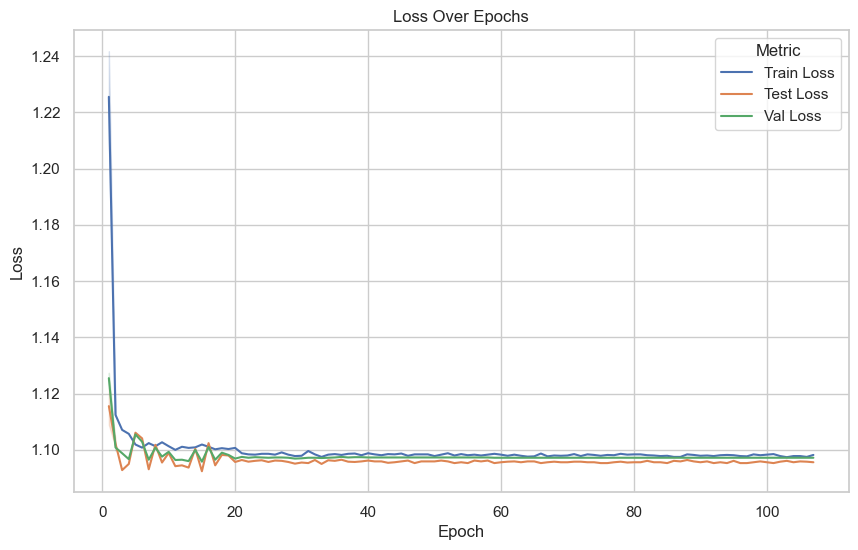

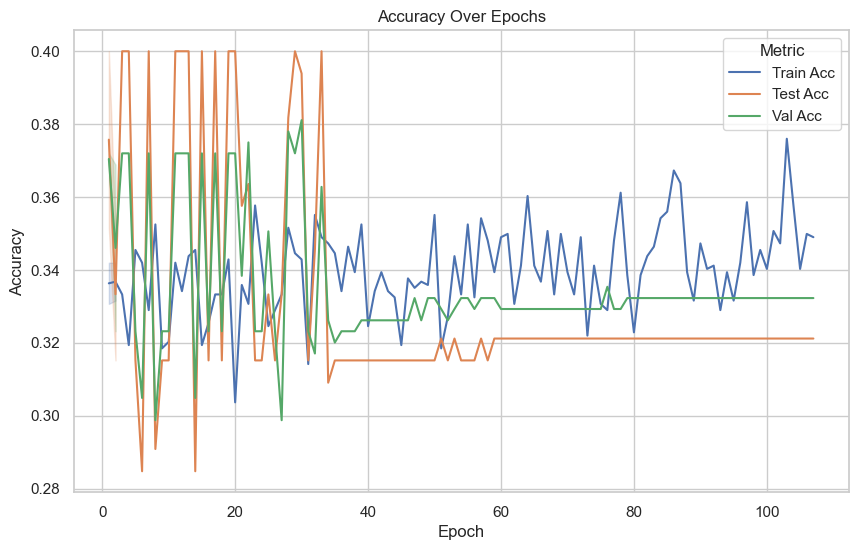

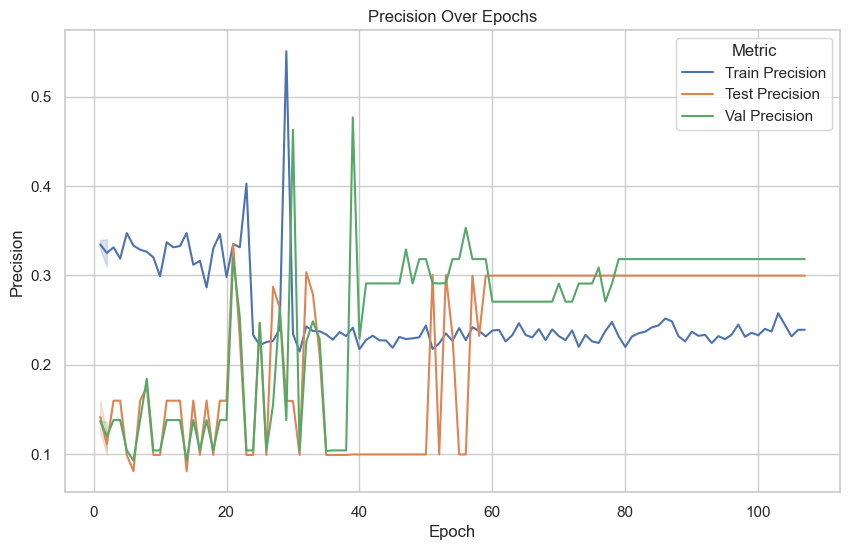

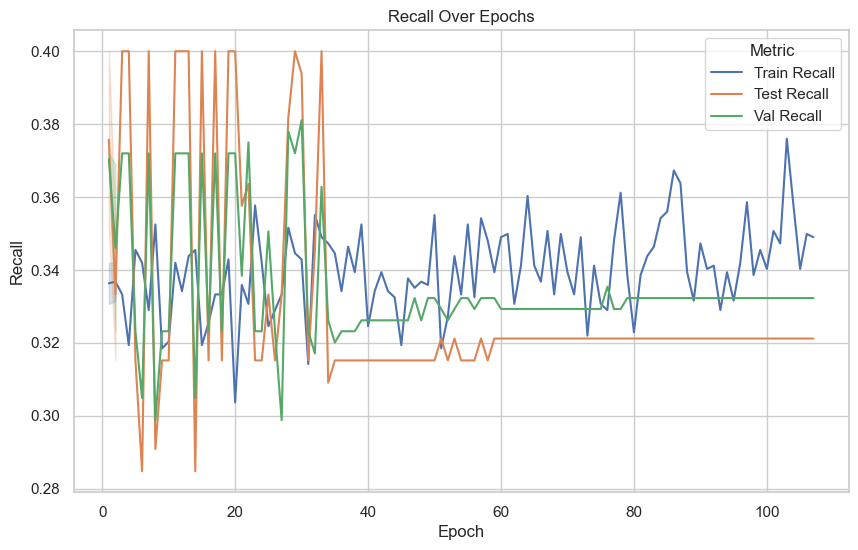

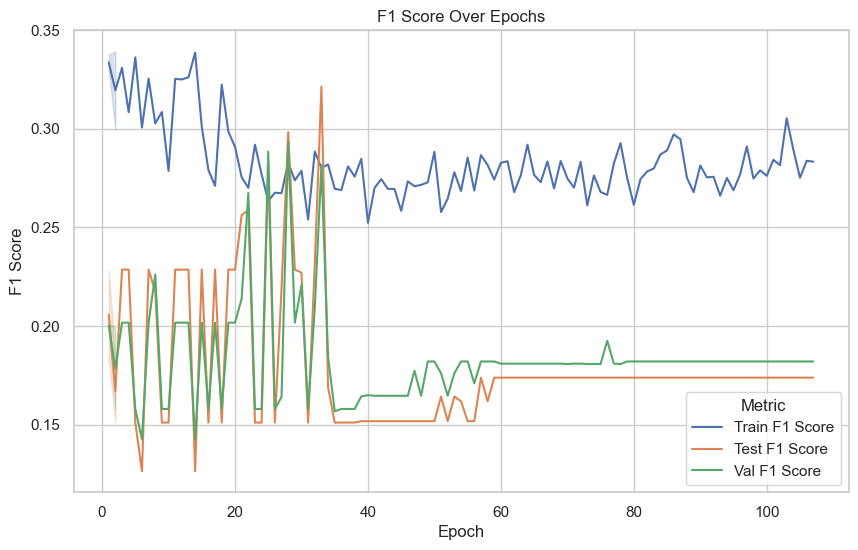

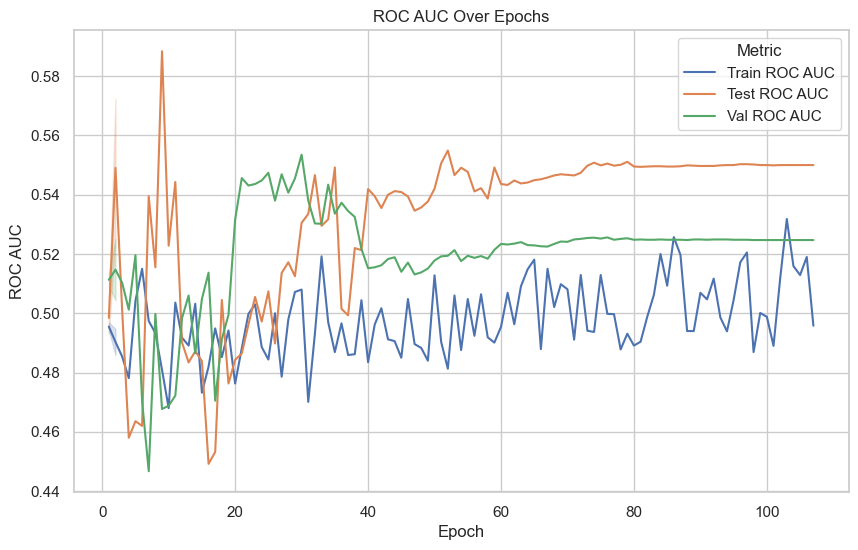

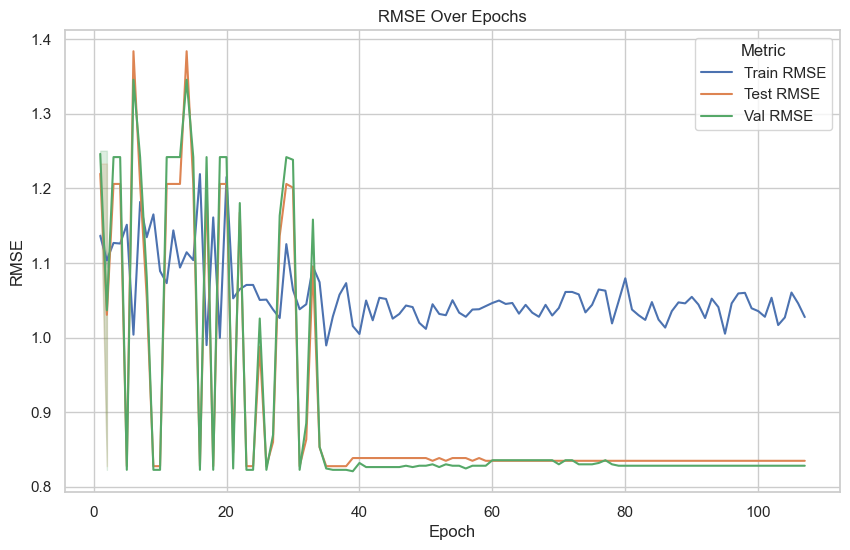

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the dataset
df_results = pd.read_csv('overall_result.csv')

# Reshape the dataframe to long format for seaborn
df_long = pd.melt(df_results, id_vars=['Epoch'], var_name='Metric', value_name='Value')

# Optional: Drop rows with NaN values in the Value column (if any)
df_long = df_long.dropna(subset=['Value'])

# Set up the plots with a style
sns.set_theme(style="whitegrid")

# Plot Loss (Train, Test, Val)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long[df_long['Metric'].isin(['Train Loss', 'Test Loss', 'Val Loss'])],
             x='Epoch', y='Value', hue='Metric')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Metric')
plt.show()

# Plot Accuracy (Train, Test, Val)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long[df_long['Metric'].isin(['Train Acc', 'Test Acc', 'Val Acc'])],
             x='Epoch', y='Value', hue='Metric')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Metric')
plt.show()

# Plot Precision (Train, Test, Val)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long[df_long['Metric'].isin(['Train Precision', 'Test Precision', 'Val Precision'])],
             x='Epoch', y='Value', hue='Metric')
plt.title('Precision Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(title='Metric')
plt.show()

# Plot Recall (Train, Test, Val)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long[df_long['Metric'].isin(['Train Recall', 'Test Recall', 'Val Recall'])],
             x='Epoch', y='Value', hue='Metric')
plt.title('Recall Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(title='Metric')
plt.show()

# Plot F1 Score (Train, Test, Val)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long[df_long['Metric'].isin(['Train F1 Score', 'Test F1 Score', 'Val F1 Score'])],
             x='Epoch', y='Value', hue='Metric')
plt.title('F1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(title='Metric')
plt.show()

# Plot ROC AUC (Train, Test, Val)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long[df_long['Metric'].isin(['Train ROC AUC', 'Test ROC AUC', 'Val ROC AUC'])],
             x='Epoch', y='Value', hue='Metric')
plt.title('ROC AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.legend(title='Metric')
plt.show()

# Plot RMSE (Train, Test, Val)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long[df_long['Metric'].isin(['Train RMSE', 'Test RMSE', 'Val RMSE'])],
             x='Epoch', y='Value', hue='Metric')
plt.title('RMSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend(title='Metric')
plt.show()
